# Machine Learning Nanodegree - Capstone project

# Flower classification

Import necessary Python packages (for loading, plotting, and augmenting data, building Neural Network, etc...)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
import json

from keras import backend as k
from keras import optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm
from scipy.io import loadmat
from collections import Counter
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

%matplotlib inline

Using TensorFlow backend.


Splitting into three folders: Train, validation, Test. And setup hyper-parameters for tuning later.

In [2]:
# test_labels_dir = '../files/imagelabels.mat'
# benchmark_model_dir = '../models/benchmark_model.h5'
# best_model_dir = '../models/best_model.h5'
# final_model_dir = '../models/final_model.h5'
# data_dir = '../flower_data'

test_labels_dir = '../input/test-file/imagelabels.mat'
benchmark_model_dir = 'benchmark_model.h5'
best_model_dir = 'best_model.h5'
final_model_dir = 'final_model.h5'
data_dir = '../input/flower-data-2/flower_data/flower_data'

cat_to_name_dir = 'cat_to_name.json'
TRAIN, VAL, TEST = 'train', 'valid', 'test'

train_in_file = os.path.join(data_dir, TRAIN)
valid_in_file = os.path.join(data_dir, VAL)
test_in_file = os.path.join(data_dir, TEST)
categories_in_file = os.path.join(data_dir, cat_to_name_dir)

# Hyper-parameters
input_size = (224, 224) # This size is dertermined by the size from VGG-19
channels = 3 # RGB
epochs = 30
transform_ratio = 0.2 # For Data augmentation aggressiveness 
batch_size = 64
rescale_ratio = 1.0 / 255.0 # (RGB)
num_unfrozen_layers = 6 # for freezing layers later during Transfer Learning (we will create 6 custom layers)

In [3]:
# Save checkpoint in a target directory with accuracy
def get_checkpoint(target_directory):
     return ModelCheckpoint(
        target_directory,
        monitor='val_acc',
        save_best_only=True,
        verbose=1
    )

early_stopping = EarlyStopping(
    monitor='val_acc',
    mode='auto',
    min_delta=0.0, # Tuning this parameter for smallest amount to be `improvement`
    patience=5, # number of epochs with no improvement after which we stop
    verbose=1
)

In [107]:
test_labels = loadmat(test_labels_dir)['labels'][0][:1000]
print(Counter(test_labels))

Counter({77: 251, 73: 194, 89: 183, 81: 166, 88: 152, 46: 54})


# Data augmentation

Create Image generators for our flower data structure to have more options for our training model.

In [108]:
## Augmentation configuration is applied to Image Data Generator for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rescale=rescale_ratio,
    rotation_range=25,
    zoom_range=transform_ratio,
    shear_range=transform_ratio,
    cval=transform_ratio,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rescale=rescale_ratio,
    rotation_range=25,
    zoom_range=transform_ratio,
    shear_range=transform_ratio,
    cval=transform_ratio,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [109]:
## Create Data generators for each folders, loading from given directories
train_generator = train_datagen.flow_from_directory(
    directory=train_in_file,
    target_size=input_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical", # Since we have more then 2 classes to predict
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_in_file,
    target_size=input_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

test_generator = test_datagen.flow_from_directory(
    directory=test_in_file,
    target_size=input_size,
    color_mode="rgb",
    batch_size=1, # A number which divides total number of test images
    class_mode=None, # To return only the images
    shuffle=False # Set to False to make the images are tested in order
)

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Found 819 images belonging to 1 classes.


In [110]:
## Step sizes to fit and train our model later
train_step_size = train_generator.n // train_generator.batch_size
valid_step_size = valid_generator.n // valid_generator.batch_size

## Mapping Test label into JSON file
Displaying the test flower names from source as ground truth labels. We will compare these labels with our predictions produced by our trained model.

In [129]:
with open(categories_in_file) as json_file:
    flower_names = json.load(json_file)
    test_flower_names = [flower_names[str(label)] for label in test_labels[:len(test_generator.filenames)]]

print(set([(flower_names[str(label)], label) for label in test_labels][:len(test_generator.filenames)]))

{('passion flower', 77), ('watercress', 89), ('cyclamen', 88), ('water lily', 73), ('frangipani', 81)}


# Data visualization

In [185]:
flower_images = []
start_index, num_samples = 2, 5

for index in range(start_index, start_index+num_samples):
    flower_images.append(glob.glob(train_in_file + '/{}/*'.format(index))[:num_samples])
    
flower_images = np.hstack(flower_images)

In [188]:
def display_image(img_paths, image_label=None, predicted_label=None):
    fig = plt.figure(figsize=(25, 20))
    indices = np.hstack([[i]*num_samples for i in range(start_index, start_index+num_samples+1)])
    
    for index in range(len(img_paths)):
        ax = fig.add_subplot(num_samples, len(img_paths)//num_samples, index+1, xticks=[], yticks=[])
        img = cv2.imread(img_paths[index])
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(cv_rgb) # and convert from Tensor image

        flower_name = flower_names["{}".format(indices[index])]
        ax.set_title(flower_name)
#         ax.set_xlabel("This is {}".format(predicted_label))

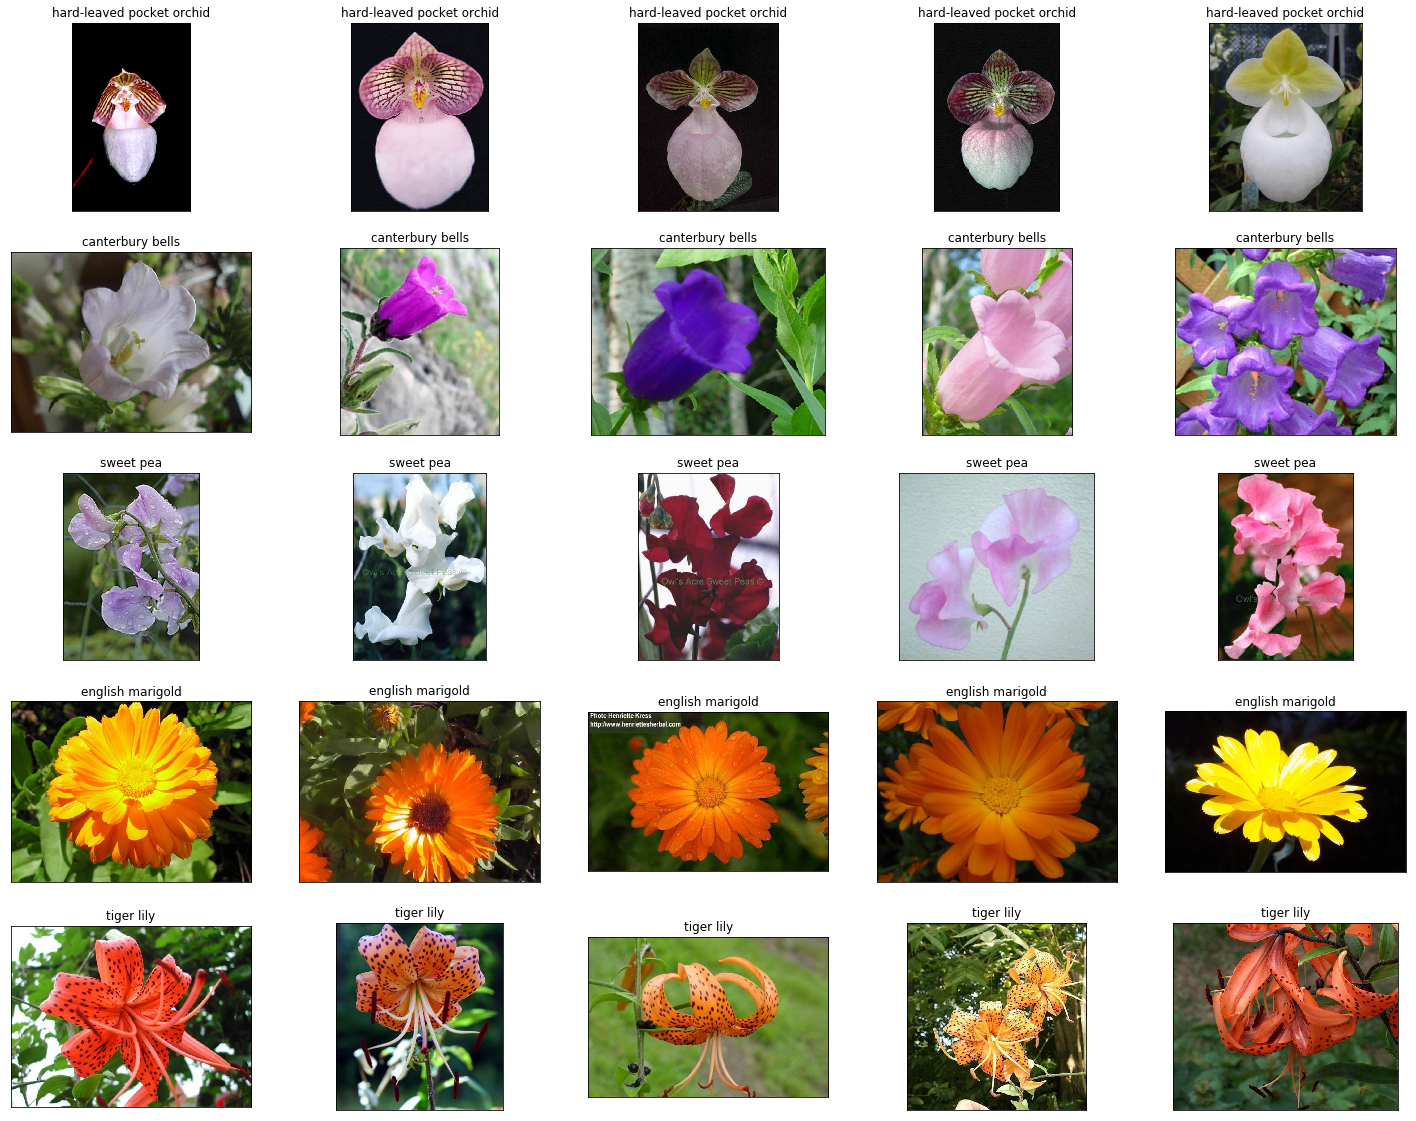

In [189]:
display_image(flower_images)

# Benchmark model
Using a very simple custom CNN to make sure our data was loaded correctly and working properly.

In [ ]:
bench_model = Sequential()
bench_model.add(Conv2D(256, kernel_size=2, input_shape=(224, 224, 3), activation='relu'))
bench_model.add(GlobalAveragePooling2D())
bench_model.add(Dropout(0.5))
bench_model.add(Dense(128, activation='relu'))
bench_model.add(Dropout(0.2))
bench_model.add(Dense(train_generator.num_classes, activation='softmax'))

In [ ]:
## Create our main model
predicted_model = Model(inputs=bench_model.input, outputs=bench_model.output)
predicted_model.summary()

In [ ]:
## Compile our model
predicted_model.compile(
    loss='categorical_crossentropy', # Since we have multi-class categories in our dataset
    optimizer=optimizers.adam(1e-3),
    metrics=['accuracy']
)

## Getting callbacks
checkpoint = get_checkpoint(benchmark_model_dir)
callbacks = [checkpoint, early_stopping]

In [ ]:
## Training model
training_history = predicted_model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_step_size,
    validation_steps=valid_step_size,
    epochs=epochs // 6,
    verbose=1,
    callbacks=callbacks
)

As expected, a benchmark model built with simple architecture containing only a few Dense layers is definitely not enough to produce good result, since this model knows nothing about our current dataset. 

We will need a model with more knowledge on lower levels, to extract the foundation features out from the given images, using a pre-trained model such as VGG-19, which has already been trained on ImageNet through 1000 images. This way we can modify this pre-trained model using Transfer Learning technique to solve our unique problem with customized Dense layers.

## Model creation - VGG-19 Transfer Learning

Download VGG-19 with pre-trained weights from ImageNet. We then exclude its top layer since we want to predict our own 102 different categories of flower.

In [ ]:
base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(input_size[0], input_size[1], channels)
)

In [ ]:
def inspect_model(model):
    for index, layer in enumerate(base_model.layers):
        print('Layer #{}: {} - Trainable: {}\nWeights: {}\n'.format(index, layer, layer.trainable, layer.trainable_weights))

In [ ]:
inspect_model(base_model)

In [ ]:
############################################################################
# Since our data is similar to images in ImageNet database, and it
# can be considered as small (only few thousands of images in total),
# we can freeze the all the layers except the fully-connected (FC) layers
# since we can expect the higher-level featuers in the pre-trained model
# to be relevant to our data, so we only train them (the FC layers).
############################################################################

## Here we train only the top layers by freezing all the layers that are already pre-trained
for layer in base_model.layers:
    layer.trainable = False
    
# Now add some custom layers into our model
net = Flatten(name='flatten')(base_model.output)
net = Dense(4096, activation='relu')(net)
net = Dropout(0.5)(net)
net = Dense(4096, activation='relu')(net)
net = Dropout(0.5)(net)
net = Dense(train_generator.num_classes, 
            activation='softmax')(net) # 102 output classes

In [ ]:
# Create our main model
predicted_model = Model(inputs=base_model.input, outputs=net)
predicted_model.summary()
inspect_model(base_model)

In [ ]:
# Compile our model
predicted_model.compile(
    loss='categorical_crossentropy', # Since we have multi-class categories in our dataset
    optimizer=optimizers.adam(1e-5),
    metrics=['accuracy']
)

checkpoint = get_checkpoint(best_model_dir)
callbacks = [checkpoint, early_stopping]

## Training model (Simple version - freezing all convolutional layers)

In [ ]:
training_history = predicted_model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_step_size,
    validation_steps=valid_step_size,
    epochs=np.int(epochs * 1/3),
    verbose=1,
    callbacks=callbacks
)

## Losses Visualization

In [ ]:
def plot_model(trainning_history):
    train_accuracy = training_history.history['acc']
    val_accuracy = training_history.history['val_acc']
    
    train_loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    
    num_epochs = range(len(train_accuracy))
    plt.plot(num_epochs, train_accuracy, 'g', label='Training')
    plt.plot(num_epochs, val_accuracy, 'r', label='Validation')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(num_epochs, train_loss, 'b', label='Training')
    plt.plot(num_epochs, val_loss, 'r', label='Validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    plt.show()

In [ ]:
plot_model(training_history)

## Loading checkpoint with best weights for our model and fine-tune

In [ ]:
predicted_model.load_weights(best_model_dir)

In [ ]:
## Now unfreeze another last 5 layers from Convolutional base to fine-tune our model more
pretrained_model = predicted_model.layers
num_unfrozen_layers = -num_unfrozen_layers - 5

for layer in pretrained_model[:num_unfrozen_layers]:
    layer.trainable = False
for layer in pretrained_model[num_unfrozen_layers:]:
    layer.trainable = True
    
inspect_model(predicted_model.layers)
predicted_model.layers

In [ ]:
predicted_model.compile(loss='categorical_crossentropy',
                        optimizer=optimizers.adam(1e-5),
                        metrics=['accuracy'])

checkpoint = get_checkpoint(final_model_dir)
callbacks = [checkpoint, early_stopping]

In [ ]:
training_history = predicted_model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    steps_per_epoch=train_step_size,
    validation_steps=valid_step_size,
    epochs=np.int(epochs * 2/3),
    verbose=1,
    callbacks=callbacks
)

In [ ]:
plot_model(training_history)

In [ ]:
model_saved_json = predicted_model.to_json()

# with open('../models/' + 'model.json', 'w') as json_file:
with open('model.json', 'w') as json_file:
    json_file.write(model_saved_json)

## Evaluate Model

In [ ]:
predicted_model.load_weights(final_model_dir)

In [ ]:
evaluation = predicted_model.evaluate_generator(valid_generator, 
                                                steps=valid_generator.batch_size)

In [ ]:
print(evaluation)

In [ ]:
test_generator.reset()
prediction = predicted_model.predict_generator(test_generator,
                                               steps=len(test_generator.labels), verbose=1)

predicted_classes = np.argmax(prediction, axis=1)

In [ ]:
labels = dict((value, key) for key, value in train_generator.class_indices.items())
predictions = [labels[k] for k in predicted_classes]

In [ ]:
len(file_indices)

In [ ]:
file_indices = test_generator.filenames
results = pd.DataFrame({
    "Filename": file_indices,
    "Prediction": predictions,
    "Grouth truth label": test_flower_names
})
results.to_csv("results.csv", index=False)
# results.to_csv("../results/results.csv", index=False)
results

## Visualization

Drawing heatmap for confusion matrix on how well our model performs.

In [ ]:
flowers = Counter(test_labels)
flowers_names = [str(key) for key in flowers.keys()]

print(flowers)

while flowers:
    print(flowers.popitem())

try:
    matrix = confusion_matrix(test_flower_names, test_flower_names)
    df = pd.DataFrame(matrix, index=flowers_names, columns=flowers_names)
    heatmap = sns.heatmap(df, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), 
                             rotation=0, ha='right', fontsize=12.0)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), 
                             rotation=45, ha='right', fontsize=12.0)

plt.xlabel('Ground Truth label')
plt.ylabel('Predicted label')

In [ ]:
## Cleanup session for backend
k.clear_session()